In [1]:
import sys,os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

# Outlier detection using Replicator Neural Network

The goal of this notebook is to implement a RNN (Replicator Neural Network) for outlier detection using the paper "Outlier Detection Using Replicator Neural Networks"

http://neuro.bstu.by/ai/To-dom/My_research/Papers-0/For-research/D-mining/Anomaly-D/KDD-cup-99/NN/dawak02.pdf 

## RNN

The RNN we use is a feed-forward multi-layer perceptron with three hidden layers sandwiched between an input layer and an output layer. The function of the RNN is to reproduce the input data pattern at the output layer with error minimised through training. Both input and output layers have n units, corresponding to the n features of the training data. 

The number of units in the three hidden layers are chosen experimentally to minimise the average reconstruction error across all training patterns.

### Comments

We implement the RNN from scratch ? 

http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

https://github.com/mateusfreira/outlier-detection-using-replicator-neural-networks/blob/master/rnn.js


We use an face's database for our use case : the croppedYale database comes from the Extended Yale Database (16128 images of 28 human subjects under 9 poses and 64 illumination conditions). See https://github.com/MaxWab/facerecog for more informations about the database. 

In [2]:
path_images = 'D:\\Users\\S37283\\Documents\\Outlier detection'

In [3]:
def read_images(path, sz=None,sz0=168,sz1=192): 
    '''
    Chargement des données
    Si spécifiée, réduction de dimensions incluse
    '''
    c=0
    X,y = [], []
    for dirname , dirnames , filenames in os.walk(path):
        for subdirname in dirnames:
            subject_path = os.path.join(dirname , subdirname) 
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path , filename)) 
                    im = im.convert("L")
                    # resize to given size (if given) and check that it's the good size
                    if ((im.size[0] == sz0) & (im.size[1]==sz1)):
                        if (sz is not None):
                            im = im.resize(sz, Image.NEAREST)     
                        X.append(np.asarray(im, dtype=np.uint8)) 
                        y.append(c)
                except IOError:
                    pass
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
            c = c+1
            
    print("Images chargees !")
    return [X,y]

In [4]:
X_original, y_original = read_images(path_images, sz=None)
X_small, y_small = read_images(path_images, sz=(12,10))

Images chargees !
Images chargees !


In [5]:
print("Nombre d'éléments chargés ",len(X_original))

Nombre d'éléments chargés  2432


In [6]:
def noise_image(image_input, per=0.5):
    '''
    Ajoute du bruit à une image : met un pourcentage de pixel à 0.
    @params:
        per : pourcentage de pixels à corrompre
    '''
    sz0 = image_input.shape[0]
    sz1 = image_input.shape[1]
    
    # Création du masque
    nb_pix_to_noise = int(np.floor(per*sz0*sz1))
    
    mask = np.ones((sz0*sz1,1))
    ids = np.random.permutation(sz0*sz1)[0:nb_pix_to_noise]
    mask[ids] = 0
    mask = np.reshape(mask,(sz0,sz1))
    
    # Matrice de pixels aléatoires (intensité entre 0 et 255)
    #rand_pix = np.random.randint(0,256,size=(sz0,sz1))
    rand_pix =np.zeros((sz0,sz1))
    
    # On retourne la matrice initiale où l'on a changé les pixels indiqués par des pixels noirs
    return np.multiply(mask,image_input) + np.multiply(1-mask,rand_pix)

In [7]:
def black_frame(array_orig, x0, x1, y0, y1):
    '''
    Ajoute un bandeau noir dont les coins sont de coordonnées (x0,y0),(x1,y1),(x0,y1) et (x1,y0)
    '''
    array_tmp = np.ones_like(array_orig)
    
    if ((x0 > array_tmp.shape[1]) | (x1 > array_tmp.shape[1]) | (y0 > array_tmp.shape[0]) | (y1 > array_tmp.shape[0])):
        print("Error : coordonnees du bandeau trop grandes pour l'image")
    
    for i in range(array_tmp.shape[1]):
        for j in range(array_tmp.shape[0]):
            if ((i >= min(x0,x1)) & (i <= max(x0,x1)) & (j >= min(y0,y1)) & (j <= max(y0,y1))):
                array_tmp[j][i] = 0
    
    return array_tmp*array_orig

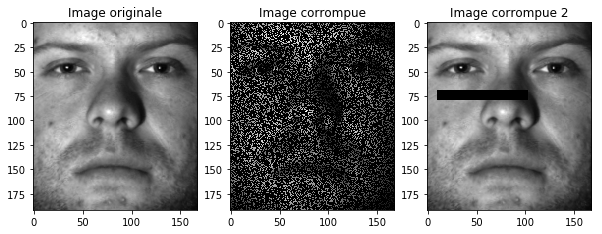

In [8]:
tmp = noise_image(X_original[12],0.7)
tmp2 = black_frame(X_original[12],10,102,79,69)
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,3,1)
plt.imshow(X_original[12], cmap='gray')
plt.title('Image originale')
plt.subplot(1,3,2)
plt.imshow(tmp,cmap='gray')
plt.title('Image corrompue')
plt.subplot(1,3,3)
plt.imshow(tmp2,cmap='gray')
plt.title('Image corrompue 2')
plt.show()

On va essayer deux études :
- Une où les zones corrompues des images ainsi bruitées seront considérées comme des outliers.
- Une où une image corrompue est considérée comme un outlier parmi des images non corrompues (on va stacker les images)

In [9]:
def outlier_factor(y_pred,y_true):
    return ((y_true - y_pred) ** 2).sum() 

## Outlier detection on one image

In [17]:
x=X_original[12]

In [18]:
x.shape

(192, 168)

In [27]:
n_units=50
mlp=MLPRegressor(hidden_layer_sizes=(stackedX.shape[1],n_units,3,n_units,stackedX.shape[1]),
                 activation='tanh',
                 learning_rate='adaptive')

In [28]:
mlp.fit(x,x)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(32256, 50, 3, 50, 32256),
       learning_rate='adaptive', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [29]:
xpred=mlp.predict(x)

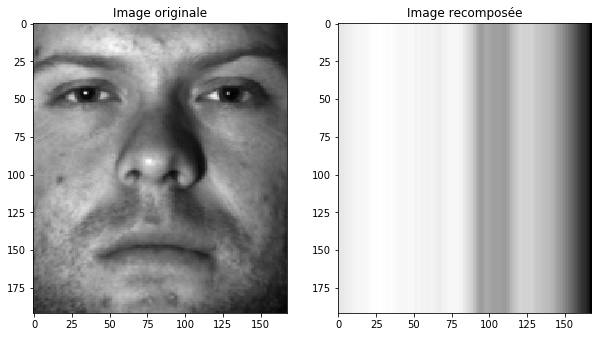

In [30]:
plt.figure(figsize=(10,12))
plt.clf()
plt.subplot(1,2,1)
plt.imshow(x, cmap='gray')
plt.title('Image originale')
plt.subplot(1,2,2)
plt.imshow(xpred,cmap='gray')
plt.title('Image recomposée')
plt.show()

## Oulier dection amoung all database

### Database construction with blackframe

On va introduire un pourcentage d'images avec un bandeau dans la base de donnée originale.

In [10]:
noisyimages=[]
noisyimages.append(black_frame(X_original[1],10,152,39,69))
noisyimages.append(black_frame(X_original[5],10,152,19,49))
noisyimages.append(black_frame(X_original[7],10,152,59,89))
noisyimages.append(black_frame(X_original[12],10,152,79,109))
noisyimages.append(black_frame(X_original[8],10,152,99,129))
noisyimages.append(black_frame(X_original[15],10,152,19,12))
noisyimages.append(black_frame(X_original[100],10,152,99,69))
noisyimages.append(black_frame(X_original[78],50,152,39,69))
noisyimages.append(black_frame(X_original[59],10,132,39,69))
noisyimages.append(black_frame(X_original[300],20,152,39,69))
noisyimages.append(black_frame(X_original[120],10,102,79,69))
noisyimages.append(black_frame(X_original[18],10,152,39,69))
noisyimages.append(black_frame(X_original[256],10,152,39,69))

In [11]:
sz0 = X_original[12].shape[0]
sz1 = X_original[12].shape[1]

In [12]:
noisyX=X_original
for elt in noisyimages:
    noisyX.append(elt)

In [13]:
X=X_original

In [14]:
stackedX=np.hstack((X[0].reshape((sz0*sz1,1)),X[1].reshape((sz0*sz1,1))))
for i in range(2,len(X)):
    stackedX=np.hstack((stackedX,X[i].reshape((sz0*sz1,1))))
    #print(i)
stackedX=np.transpose(stackedX)

In [15]:
stackedX.shape

(2445, 32256)

In [16]:
stackedX

array([[ 80,  80,  84, ...,  12,  12,  11],
       [ 94,  94,  96, ...,   6,   7,   8],
       [ 59,  66,  77, ...,   5,   7,   7],
       ..., 
       [  5,   5,   5, ..., 202, 204, 208],
       [118, 114, 118, ...,   5,   7,   8],
       [ 10,   5,   8, ..., 197, 190, 179]], dtype=uint8)

Une ligne de stakedX correspond à une image